In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSampleGraph, plotArrangement, annotateSampleGraph, plotCSV
from qubo import createBQM
from sampleRecording import recordSample, findOverlaps, totalEntropy

identifier = "Haydn-3"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
embedding = json.load(open(path + "embedding.json", "r"))
#bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [4]:
bqm = createBQM(G, phrases, instruments, 6, 6, 1)
reads = 1000
sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
#plotHistogram(sampleset.to_pandas_dataframe(True))

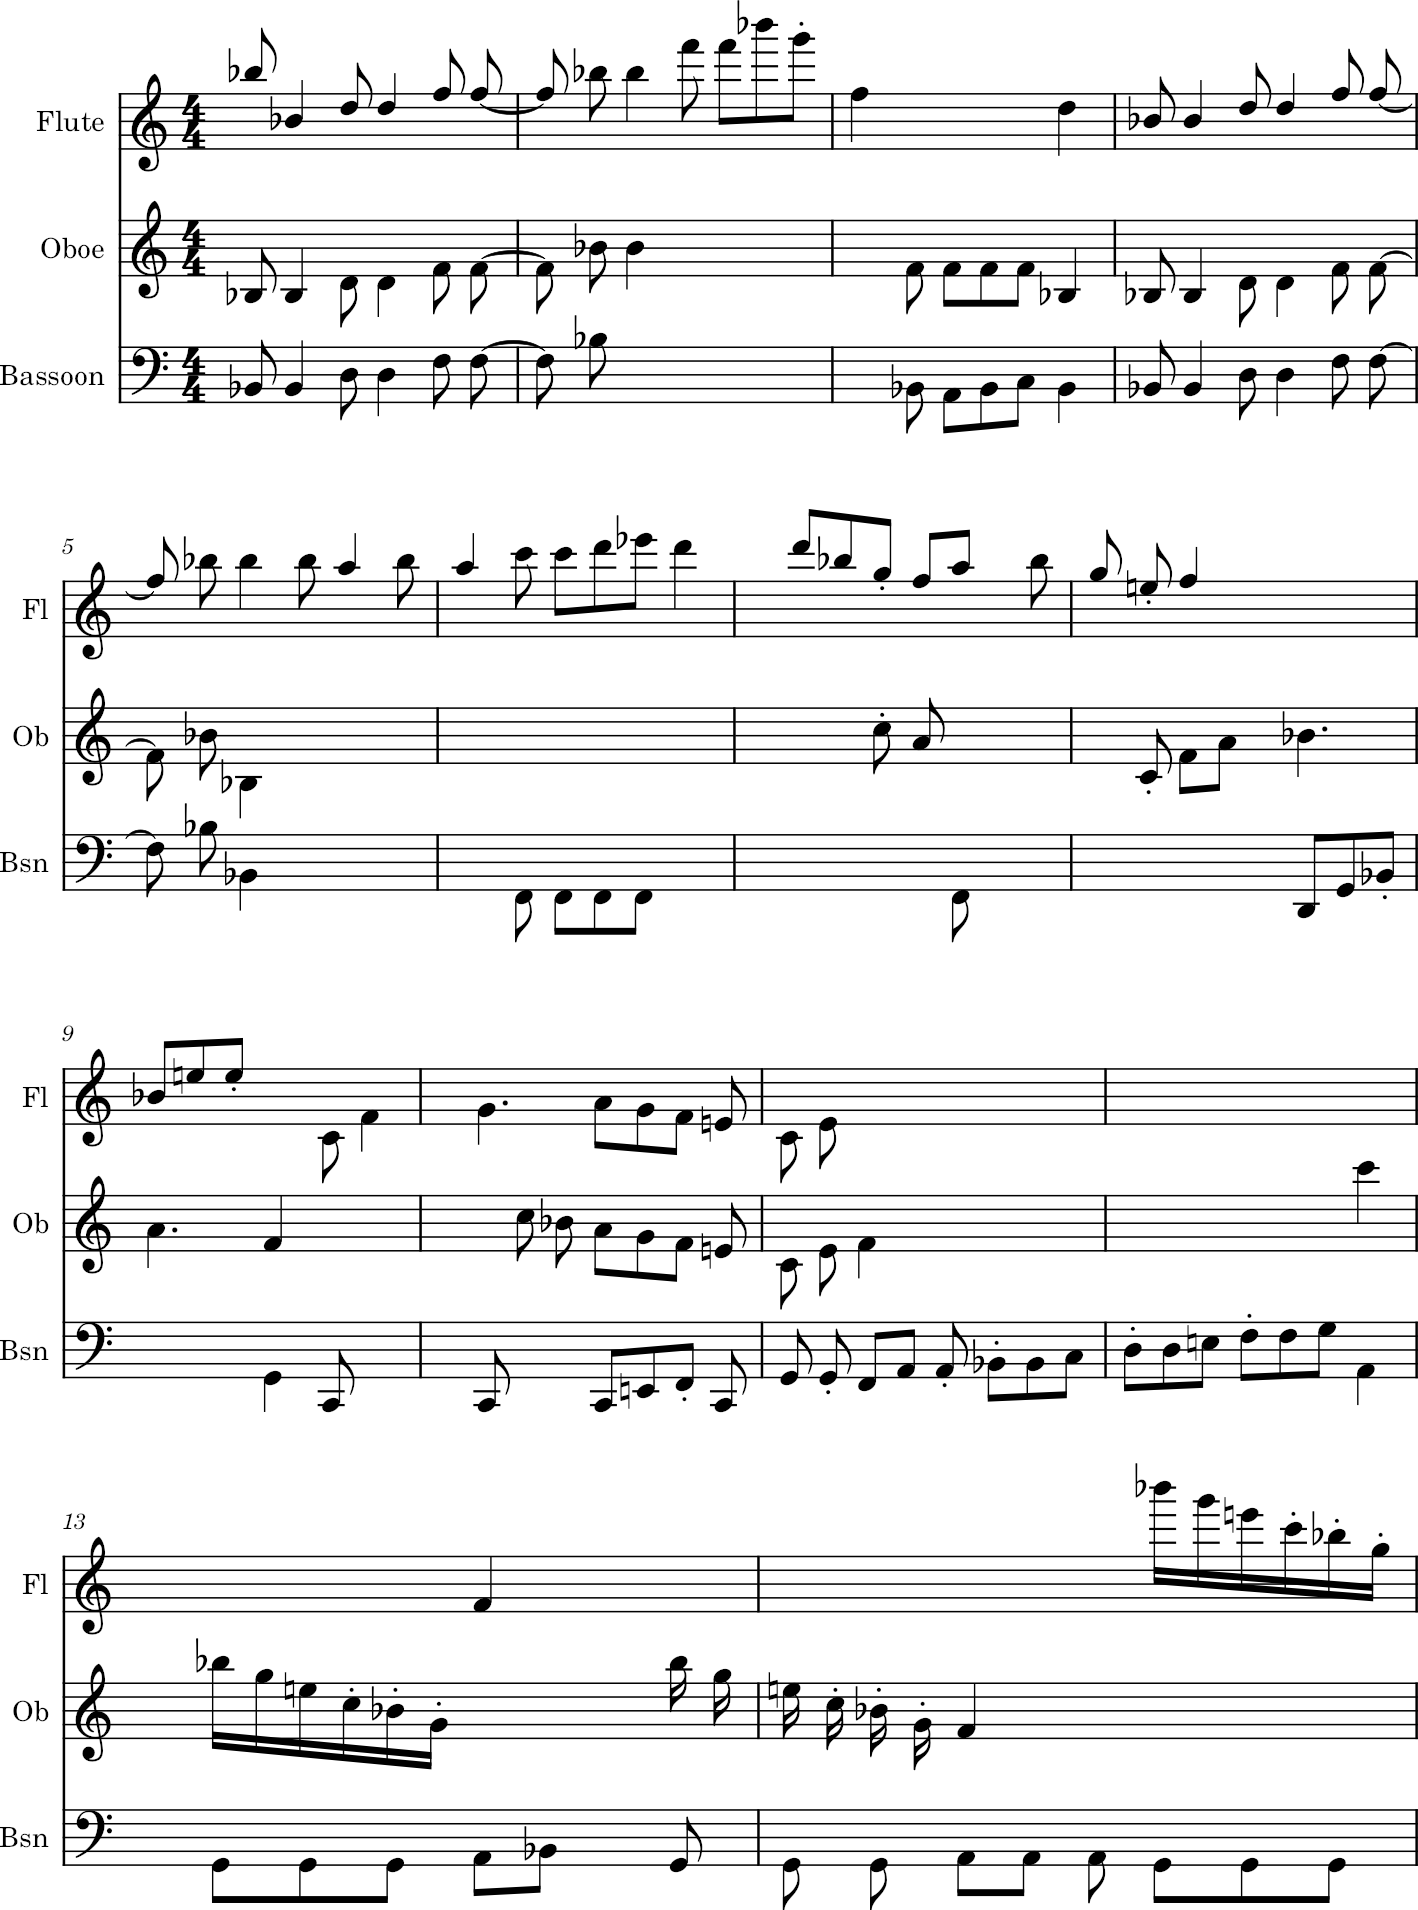

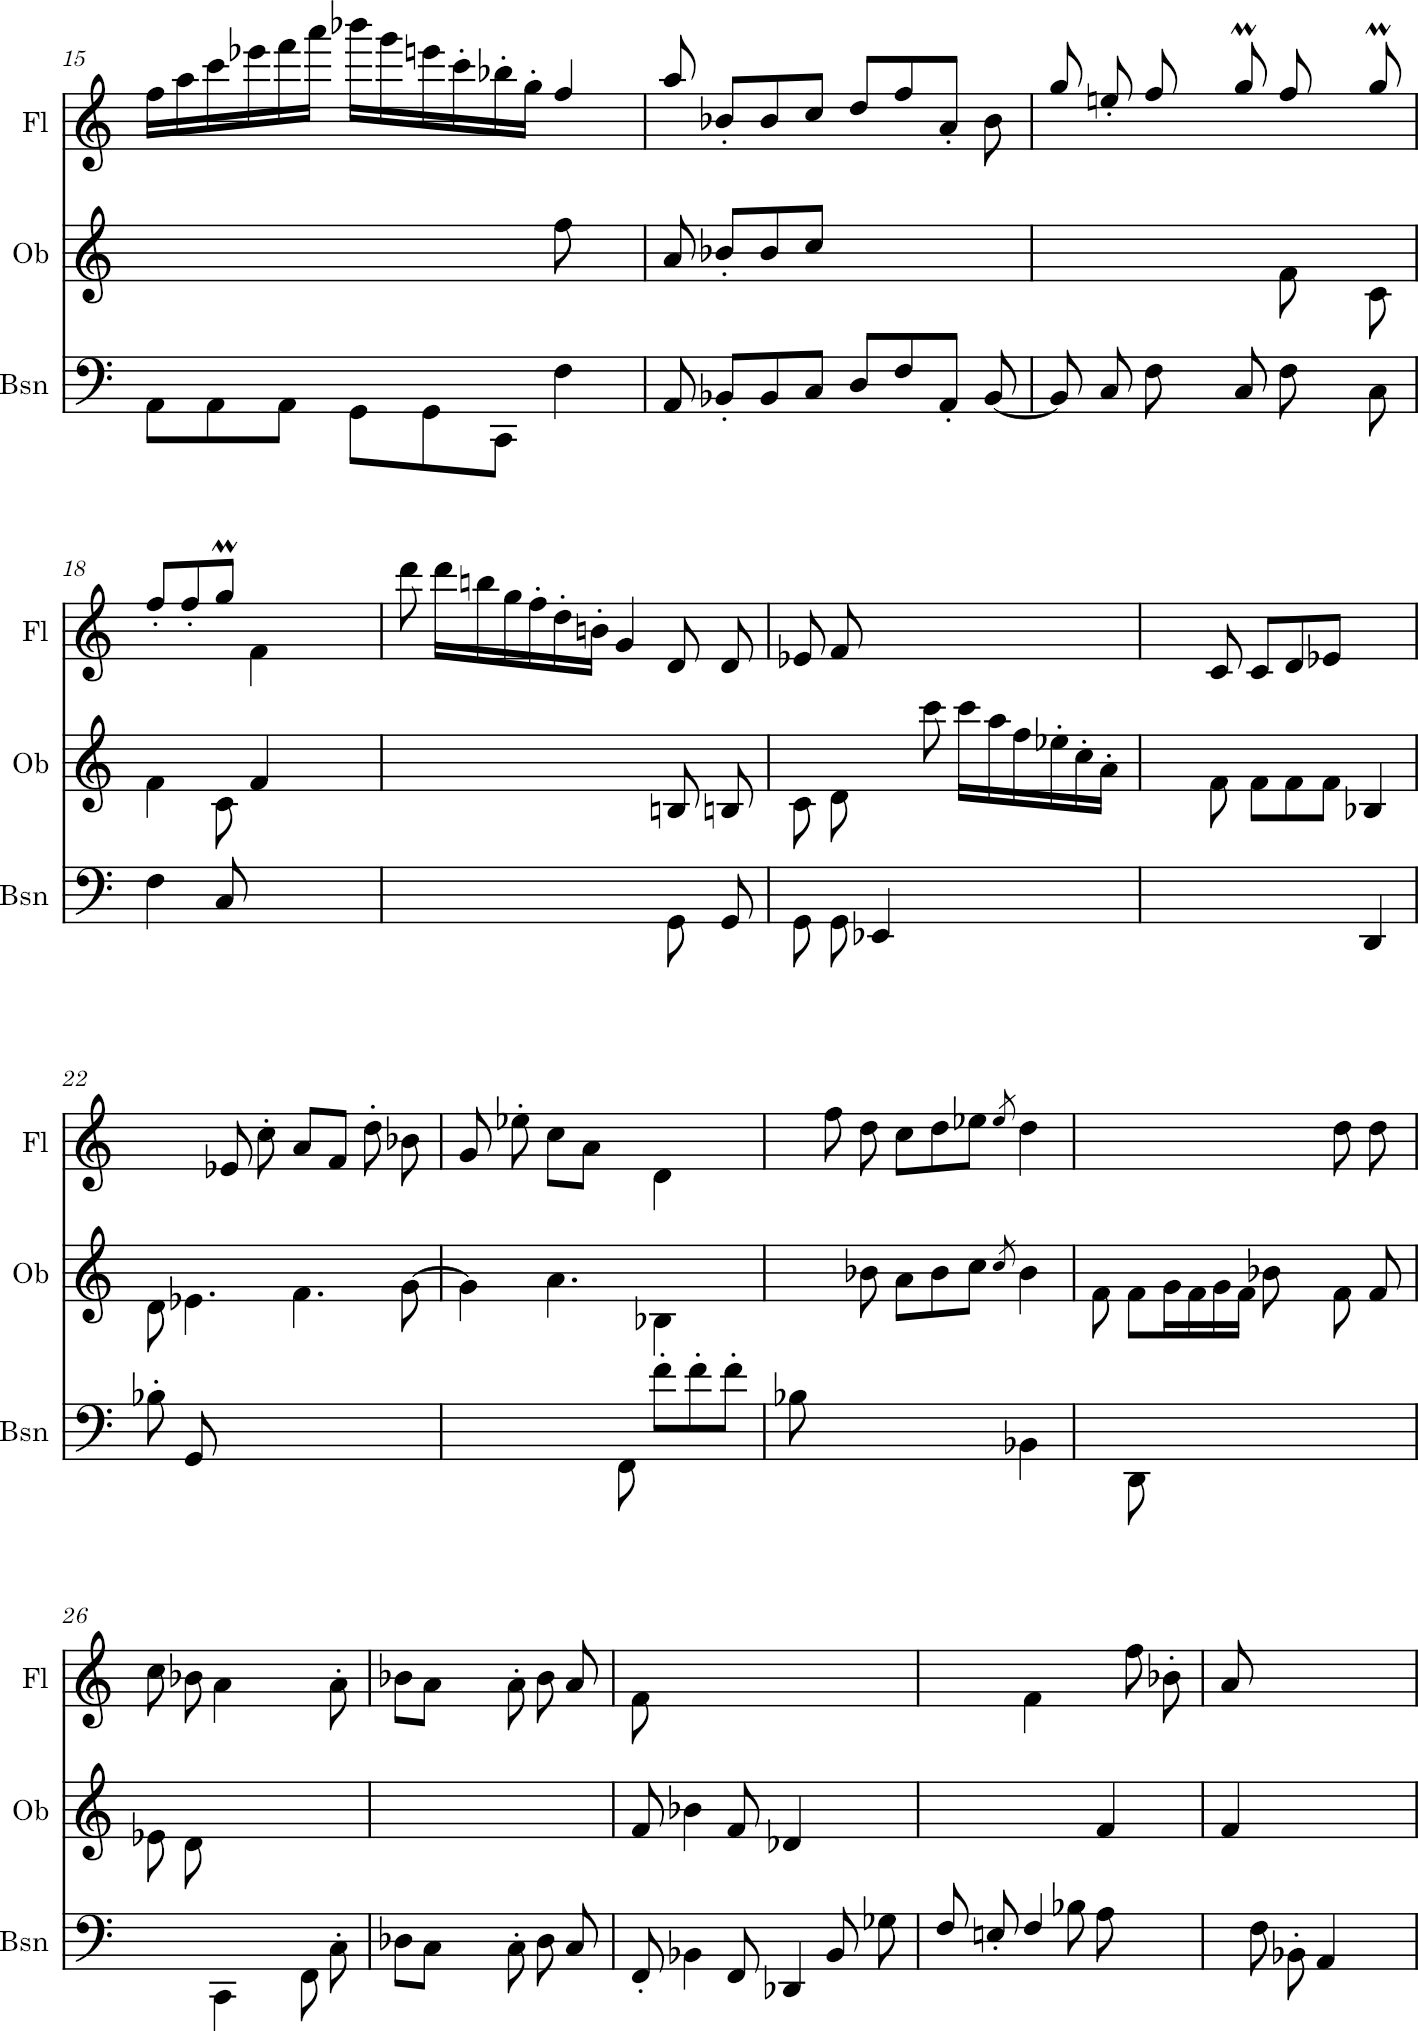

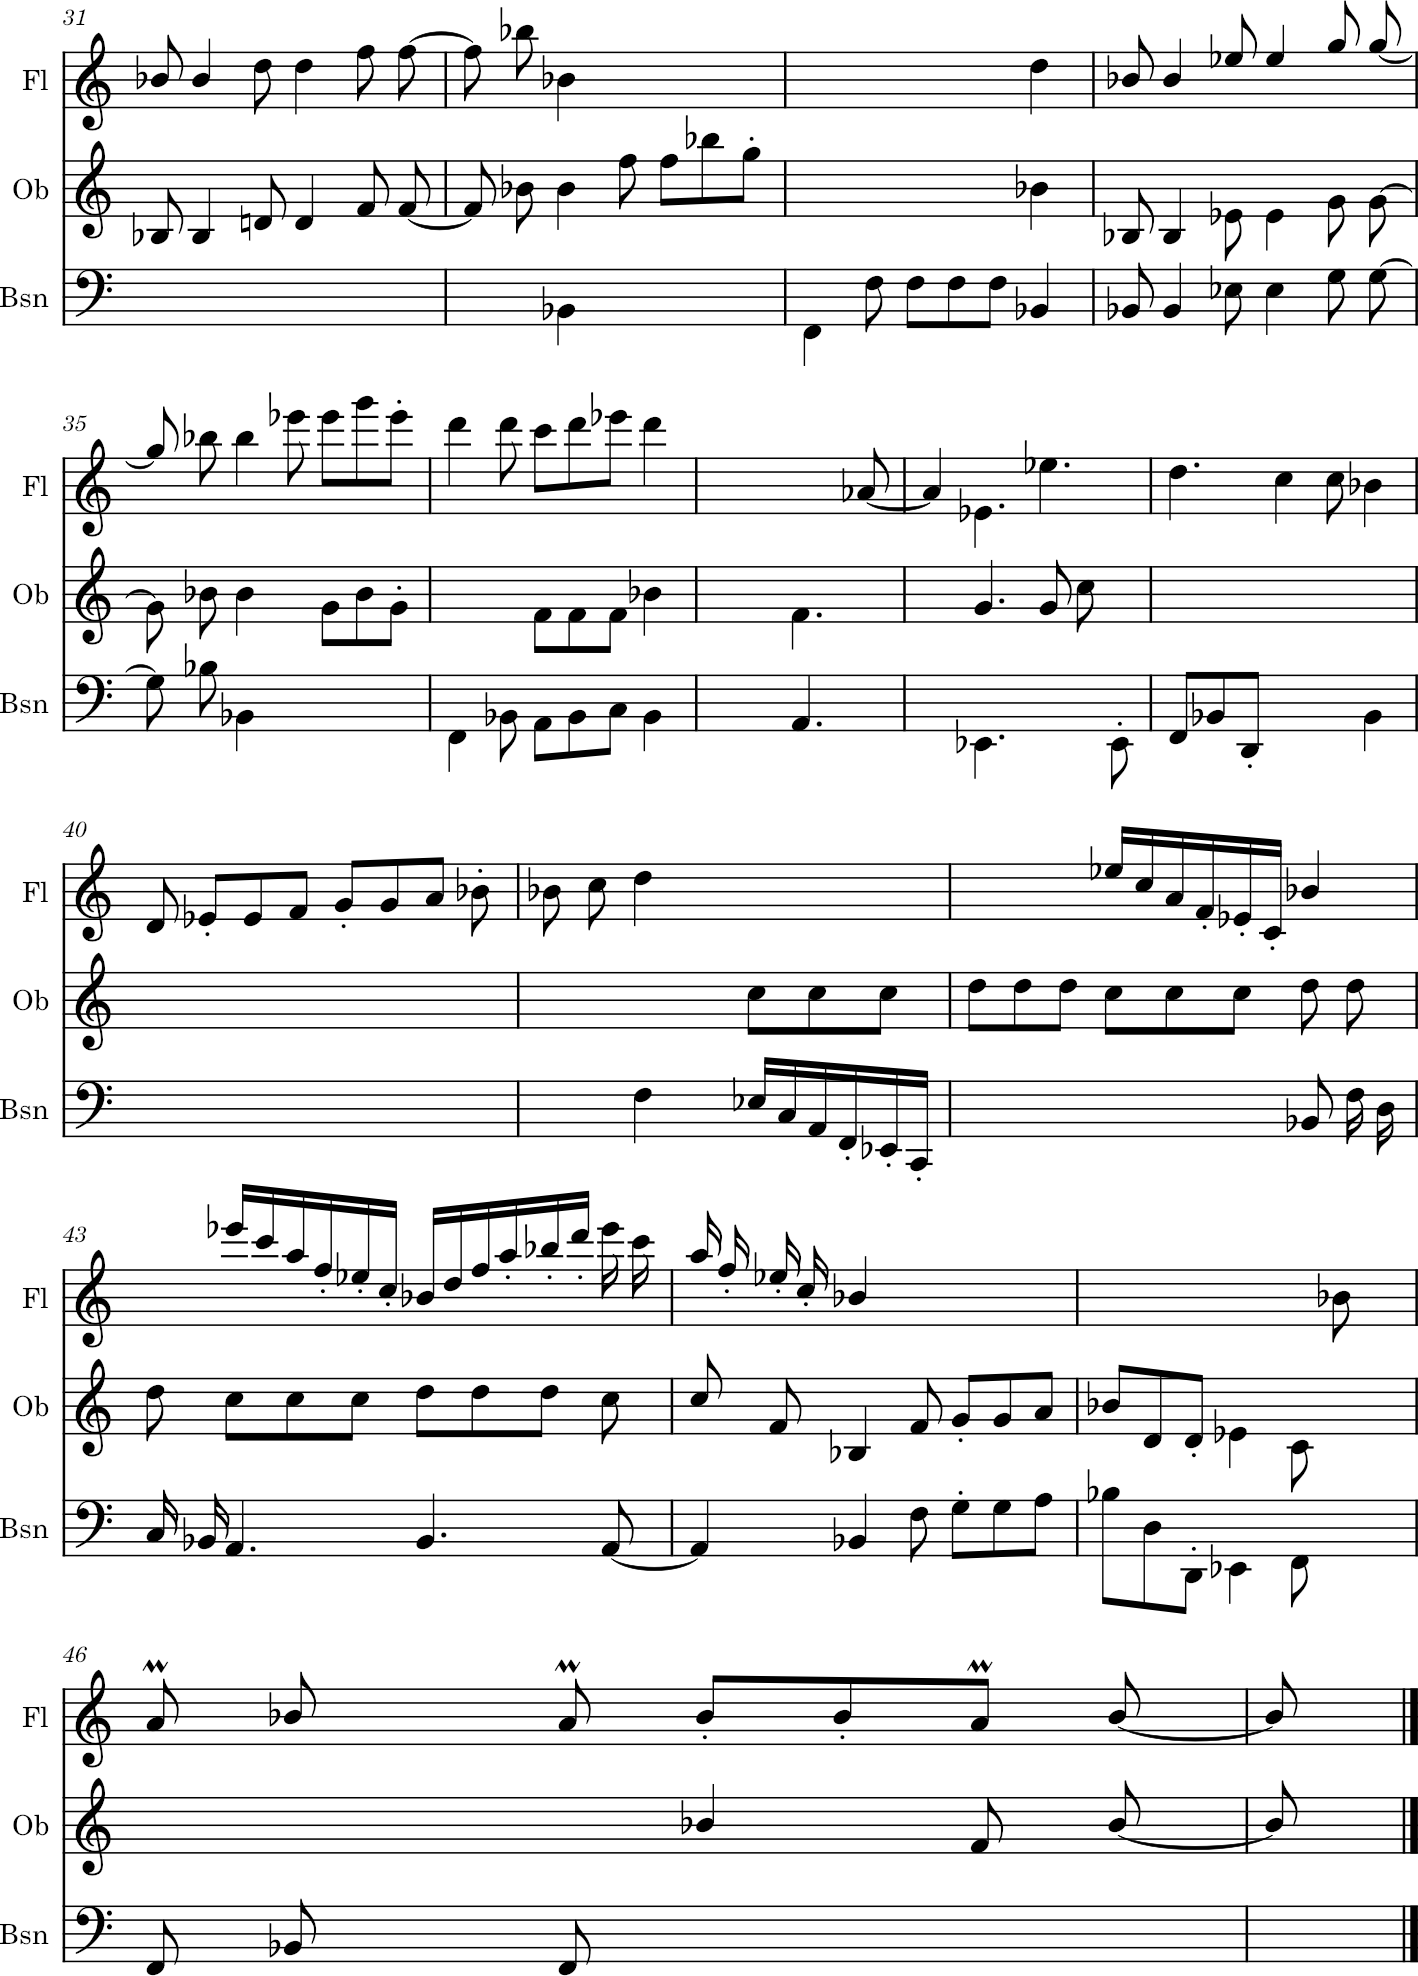

In [18]:
from music21 import stream, instrument, clef, analysis
from plotters import extractChosen

def shiftOctave(s: stream.Stream, o: int):
    for n in s.recurse().notes:
        n.octave += o

def plotArrangement(sample: dict, phrases: list, instruments: dict) -> None:
    '''
    Create an arrangement score from a sample
    '''

    allPhrases = [phrase for part in phrases for phrase in part]
    parts = {}

    for i in instruments:
        part = stream.Part()
        part.append(getattr(instrument, i)())
        part.append(getattr(clef, instruments[i]["clef"])())
        parts[i] = part

    chosen = extractChosen(sample) # phrase.id : assignment

    for phrase in allPhrases:
        if phrase.id in chosen:
            
            # Focus on JUST NOTES for now
            inst = getattr(instrument, chosen[phrase.id])()
            lowestNote = inst.lowestNote

            # Check ambitus
            p = analysis.discrete.Ambitus()
            pitchMin, _ = p.getPitchSpan(phrase)
            
            # Shift octaves to be in range
            while pitchMin.ps < lowestNote.ps or pitchMin.octave - lowestNote.octave > 1:
                shiftOctave(phrase, 1 if pitchMin.ps < lowestNote.ps else -1)

            parts[chosen[phrase.id]].mergeElements(phrase.notes.stream()) 

    arrangement = stream.Score(parts.values())
    arrangement.show("midi")
    arrangement.show()

#plotSampleGraph(sampleset.first.sample, G, instruments)
plotArrangement(sampleset.first.sample, phrases, instruments)

In [7]:
def duplicates(sample: dict) -> list:
    
    pattern = r"^(.+_\d+)_.+$"
    return [n for n in G.nodes if sum(sample[k] for k in sample if re.match(pattern, k).group(1) == n) > 1]

multipliers = np.arange(1,6.5,.5)

file = pd.DataFrame()
for m in multipliers:
    bqm = createBQM(G, phrases, instruments, m, 1, 1)
    sampleset = sampler.sample(bqm, num_reads=1000, label=f"Haydn_{1000}")
    sample = sampleset.first

    new_row = pd.DataFrame({
        "Multiplier": [m],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Duplicates": [len(duplicates(sample.sample))]
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Multiplier {m} recorded!")

file.to_csv(path+"node-constraint.csv", index=False, mode="a", header=False)

Multiplier 1.0 recorded!
Multiplier 1.5 recorded!
Multiplier 2.0 recorded!
Multiplier 2.5 recorded!
Multiplier 3.0 recorded!
Multiplier 3.5 recorded!
Multiplier 4.0 recorded!
Multiplier 4.5 recorded!
Multiplier 5.0 recorded!
Multiplier 5.5 recorded!
Multiplier 6.0 recorded!


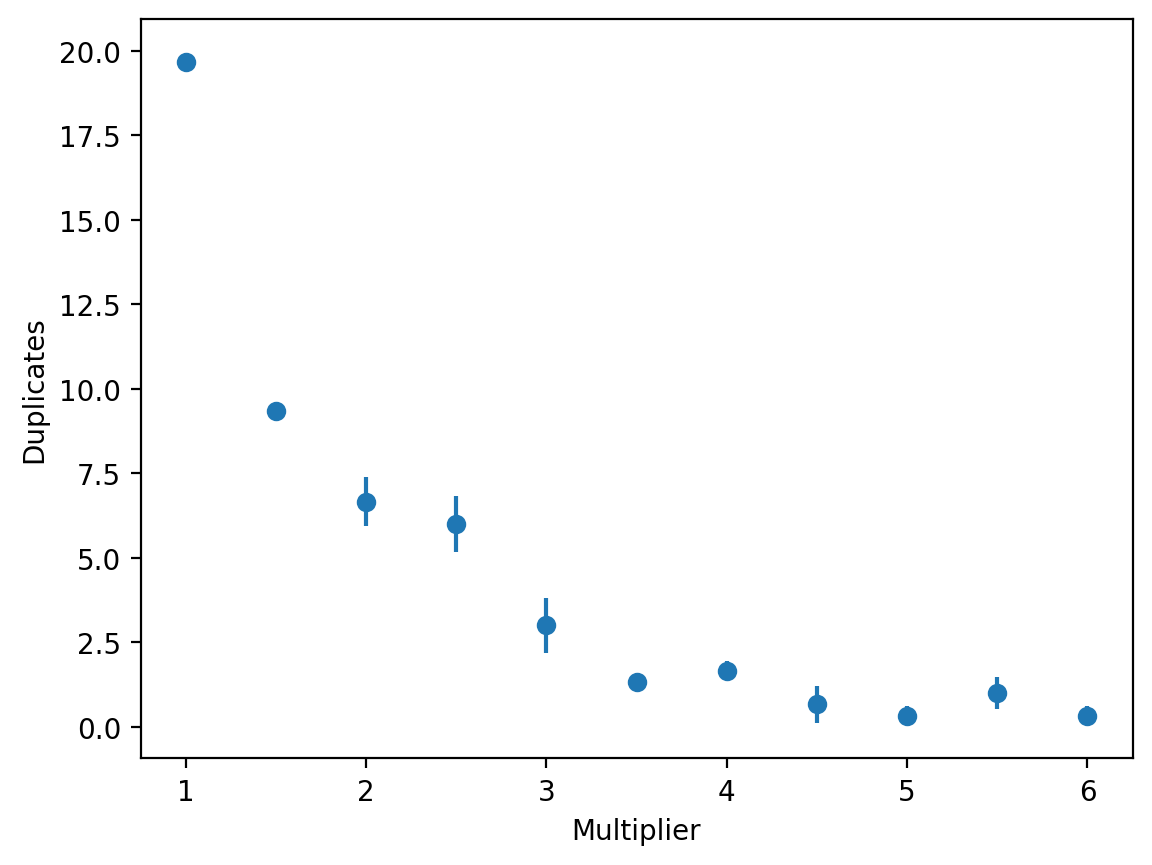

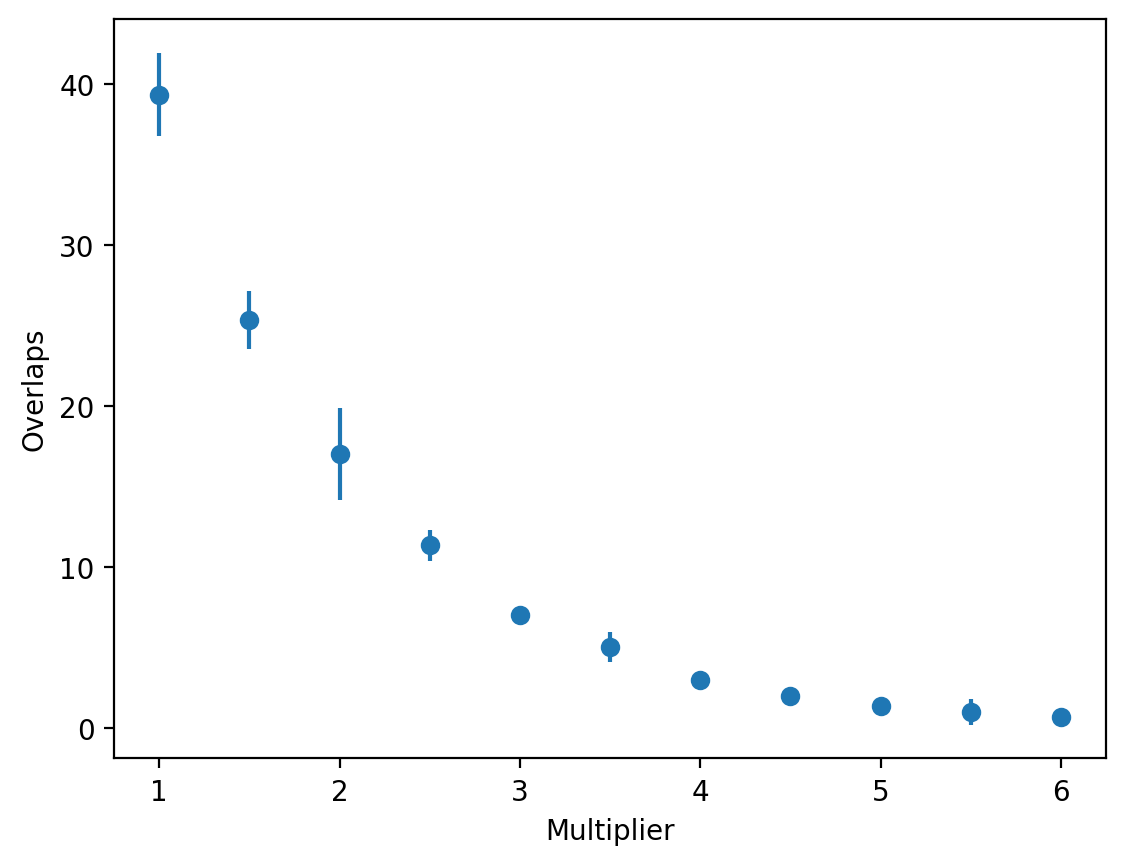

In [ ]:
plotCSV(path+"node-constraint.csv", "Multiplier", "Duplicates", np.arange(1,6.5,.5))
plotCSV(path+"edge-constraint.csv", "Multiplier", "Overlaps", np.arange(1,6.5,.5))

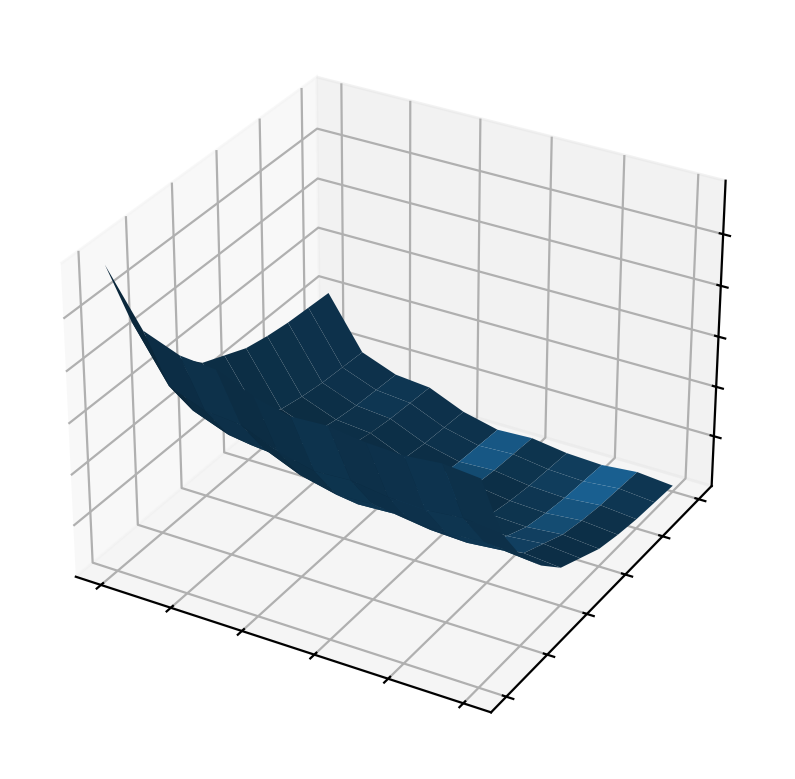

In [52]:
# Try 3D plot for Lagrange parameter analysis

node_constraint = pd.read_csv(path+"node-constraint.csv")
edge_constraint = pd.read_csv(path+"edge-constraint.csv")

def getMean(X: np.ndarray, Y: np.ndarray):
    
    Z = np.ndarray(X.shape)

    for i in range(X.shape[0]):
          for j in range(X.shape[1]):
              Z[i][j] = np.mean(node_constraint.query(f"`Multiplier` == {X[i][j]}")["Duplicates"]) + np.mean(edge_constraint.query(f"`Multiplier` == {Y[i][j]}")["Overlaps"])
    return Z


X = np.arange(1, 6.1, 0.5)
Y = np.arange(1, 6.1, 0.5)

X,Y = np.meshgrid(X,Y)
#print(X)
Z = getMean(X, Y)
#print(Z)


#Z = [np.mean(node_constraint.query(f"`Multiplier` == {x}")["Duplicates"]) for x in X] + np.mean(edge_constraint.query(f"`Multiplier` == {Y}")["Overlaps"])

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

In [14]:
# Start with both multipliers as 1
# Vary node multiplier to find best
# Vary edge multiplier to find best
# Theoretically no overlaps once both varied

# Edge multiplier = 12 prevents overlaps without increasing energy too much
# Now can vary total anneals
# Compare to energy and total entropy
# Plot with solution from classical methods

multipliers = np.arange(1,6.5,.5)

file = pd.DataFrame()
for m in multipliers:
    bqm = createBQM(G, phrases, instruments, 5, m, 1)
    sampleset = sampler.sample(bqm, num_reads=1000, label=f"Haydn_{1000}")
    sample = sampleset.first

    A = annotateSampleGraph(sample.sample, G)
    new_row = pd.DataFrame({
        "Multiplier": [m],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Overlaps": [findOverlaps(A)]
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Multiplier {m} recorded!")

file.to_csv(path+"edge-constraint.csv", index=False, mode="a", header=False)

Multiplier 1.0 recorded!
Multiplier 1.5 recorded!
Multiplier 2.0 recorded!
Multiplier 2.5 recorded!
Multiplier 3.0 recorded!
Multiplier 3.5 recorded!
Multiplier 4.0 recorded!
Multiplier 4.5 recorded!
Multiplier 5.0 recorded!
Multiplier 5.5 recorded!
Multiplier 6.0 recorded!


In [ ]:
plotCSV(path+"simulated.csv", "Total reads", "Lowest energy", np.arange(1000,20000,1000))

In [ ]:
# Classical

no_reads = range(1000, 20001, 1000)

bqm = createBQM(G, phrases, instruments, 1, 12, 1)

for total_reads in no_reads:

    sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=total_reads)

    A = annotateSampleGraph(sampleset.first.sample, G)

    new_row = pd.DataFrame({
        "Total reads": [total_reads],
        "Lowest energy": [bqm.energy(sampleset.first.sample)],
        "Overlaps": [findOverlaps(A)],
        "Total entropy": [totalEntropy(A)]
        })

    new_row.to_csv(path+"simulated.csv", index=False, mode="a", header=False)
    print(f"Recorded {total_reads} reads")

In [ ]:
# QPU

no_reads = range(6000, 20001, 1000)
max_reads = 3000

bqm = createBQM(G, phrases, instruments, 1, 12, 1)

for total_reads in no_reads:

    if total_reads <= max_reads:
        sampleset = sampler.sample(bqm, num_reads=total_reads, label=f"Haydn_{total_reads}")
    
    else:
        sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
        reads = total_reads - max_reads

        while reads > 0:
            if reads <= max_reads:
                new_sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{total_reads}_{reads}")
                reads = 0

            else:
                new_sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
                reads -= max_reads

            if new_sampleset.first.energy < sampleset.first.energy:
                sampleset = new_sampleset

    A = annotateSampleGraph(sampleset.first.sample, G)

    new_row = pd.DataFrame({
        "Total reads": [total_reads],
        "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
        "Anneal time": [sampleset.info["timing"]["qpu_anneal_time_per_sample"]],
        "QPU time": [sampleset.info["timing"]["qpu_access_time"]],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sampleset.first.chain_break_fraction],
        "Overlaps": [findOverlaps(A)],
        "Total entropy": [totalEntropy(A)]
        })

    new_row.to_csv(path+"total-reads.csv", index=False, mode="a", header=False)
    print(f"Recorded {total_reads} reads")

In [ ]:
def plotCSV(filepath: str, xaxis: str, yaxis: str, labels: list) -> None:

    data = pd.read_csv(filepath)
    labels = np.array(labels)
    norm = labels.max()

    means = np.empty_like(labels)
    stderr = np.empty_like(labels)

    for i, l in enumerate(labels):
        query = data.query(f"`{xaxis}` == {l}")[yaxis]
        means[i] = np.mean(query)
        stderr[i] = np.std(query)/np.sqrt(len(query))

    fit = lambda x, n, t, c : n*np.exp(-x/t) + c
    #coeffs, _ = curve_fit(fit, labels/norm, means, sigma=stderr)

    plt.errorbar(labels, means, yerr=stderr, fmt='o', color='white')
    #plt.plot(labels, fit(labels, coeffs[0], norm*coeffs[1], coeffs[2]), ms=0, color='tab:blue')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)

plotCSV(path+"total-reads.csv", "Total reads", "Overlaps", range(1000,20001,1000))
#plt.savefig("reads.pgf")

In [ ]:
sampler = SimulatedAnnealingSampler()
reads = 1000

results = sampler.sample(bqm, num_reads=reads)
df = results.to_pandas_dataframe(True)

plotSampleGraph(df["sample"][0], G)

plotArrangement(df["sample"][0], phrases, instruments)

In [ ]:
# Solve classically

sd = SteepestDescentSolver()
sa = SimulatedAnnealingSampler()

# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed

for reads in no_reads:
    for _ in range(5):
        results = sa.sample(bqm, num_reads=reads)
        new_row = pd.DataFrame({
            "Total reads": [reads],
            "Lowest energy": [results.first.energy],
        })

        new_row.to_csv(path + "simulated.csv", index=False, mode="a", header=False)

    print(f"Recorded {reads} reads")

In [ ]:
print(results.info.keys())
print(results.info["embedding_context"]["chain_strength"])
print(results.info["timing"]["qpu_anneal_time_per_sample"])
print(results.info["timing"]["qpu_access_time"])
print(results.info["timing"])
print(results.first.energy)
print(bqm.energy(results.first.sample))
print(results.first.sample)
print(results.first.chain_break_fraction)

In [ ]:
plotHistogram(df)
print(df.head())
print(bqm.energy(df["sample"][0]))

In [ ]:
chain_strengths = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 500
anneal_time = 400

for cs in chain_strengths:
    sampleset = sampler.sample(bqm, num_reads=reads, annealing_time=300, chain_strength=cs, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)
    plt.subplot(3, 3, chain_strengths.index(cs)+1, sharex=True, sharey=True)
    plt.title(f"Chain Strength: {cs}")
    plotHistogram(sampleset)

plt.show()

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# DONE: Bias selection of phrases to specific parts by entropy
# TODO: Octave shift phrases to fit within instrument ranges
# TODO: Analytic Lagrange parameter analysis
# TODO: Add meaningful edge weightings
# TODO: Are there more efficient ways to add constraints?

# TODO: Solution quality against problem size
# TODO: Number of qubits (in embedding) against problem size
# TODO: Time to solution against problem size